In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Linear Regression


# PREPROCESSING

In [ ]:
df = pd.read_csv("../data/process/clean_ai_salary_2025_merged_final.csv")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14517 entries, 0 to 14516
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  14517 non-null  object 
 1   job_title               14517 non-null  object 
 2   salary_usd              14517 non-null  int64  
 3   salary_currency         14517 non-null  object 
 4   experience_level        14517 non-null  object 
 5   employment_type         14517 non-null  object 
 6   company_location        14517 non-null  object 
 7   company_size            14517 non-null  object 
 8   employee_residence      14517 non-null  object 
 9   remote_ratio            14517 non-null  int64  
 10  required_skills         14517 non-null  object 
 11  education_required      14517 non-null  object 
 12  years_experience        14517 non-null  int64  
 13  industry                14517 non-null  object 
 14  posting_date            14517 non-null

# CONSIDERING WHICH FEATURES TO USE TO TRAIN THE MODEL

Can reference https://link.springer.com/article/10.1007/s41939-025-01074-w
where we did a similar process. Inspired by Li, who used Spearman correlation and sensitivity analysis to identify influential predictors, we analyze correlations between our features and salary to guide feature selection

## Example: Job Description vs Salary is too noisy

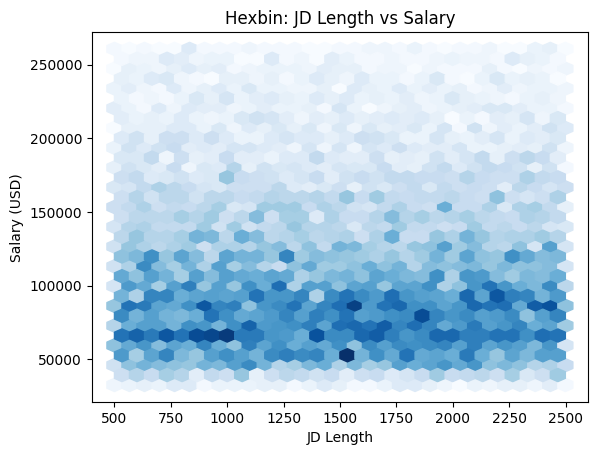

In [ ]:
df["job_description_length"].corr(df["salary_usd"])
plt.hexbin(df["job_description_length"], df["salary_usd"], gridsize=30, cmap="Blues")
plt.xlabel("JD Length")
plt.ylabel("Salary (USD)")
plt.title("Hexbin: JD Length vs Salary")
plt.show()


# Utilizing numeric feature for correlation checking
- Years of Experience has the strongest correlate at 0.74

In [ ]:
numeric_df = df.select_dtypes(include=["int64","float64"])
numeric_df.corr()["salary_usd"].sort_values(ascending=False)

,salary_usd
salary_usd,1.000000
years_experience,0.743224
remote_ratio,0.013149
benefits_score,0.001812
job_description_length,-0.009467


# Categorical Features
In theory, these features should influence salary
- Experience Level
- Job Title
- Company Level
- Education Requirements

In [ ]:
df["experience_level"].value_counts()

,count
experience_level,
MI,3781
SE,3741
EN,3718
EX,3277


In [ ]:
df["job_title"].value_counts().head(10)


,count
job_title,
ML Engineer,1502
AI Research Scientist,1440
Data Scientist,1408
Machine Learning Researcher,777
Autonomous Systems Engineer,764
Robotics Engineer,740
AI Architect,740
NLP Engineer,739
Head of AI,739


In [ ]:
df["company_location"].value_counts().head(10)


,count
company_location,
Germany,797
Austria,765
France,764
China,763
Canada,762
India,754
Israel,751
Ireland,750
Singapore,746


In [ ]:
df["education_required"].value_counts()


,count
education_required,
Bachelor,3671
Associate,3663
Master,3614
PhD,3569


# Check for missing values

In [ ]:

df.isnull().sum()


,0
job_id,0
job_title,0
salary_usd,0
salary_currency,0
experience_level,0
employment_type,0
company_location,0
company_size,0
employee_residence,0
remote_ratio,0


# Final Feature Set

In [ ]:
numeric_features = ["years_experience", "remote_ratio"]
categorical_features = [
    "experience_level",
    "job_title",
    "company_location",
    "education_required"
]

X = df[numeric_features + categorical_features]
y = df["salary_usd"]


In [ ]:
# Fill numeric NaNs with median
for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())

# Fill categorical NaNs with mode
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])


/tmp/ipython-input-3553990115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].median())
/tmp/ipython-input-3553990115.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mode()[0])


# Ordinary Least Squares Method


In [ ]:
# Pipeline for numeric columns: just scale them
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Transformer for categorical columns: one-hot encode them
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Combine them into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [ ]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 80-20 split
    random_state=42
)

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['years_experience',
                                                   'remote_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'job_title',
                                                   'company_location',
                                                   'education_required'])])),
                ('regressor', LinearRegression())])

# Summary
This should return the following:
- R^2 = 0.824

  - This is the coefficient of determination. It measure how much of the variation in the salary that our model can explain. "Accuracy".
  This the great for a linear reg. model when the salary is noisy, job titles vary widely, and countries differ ramatically.

- MAE ~= $16,198

  - Mean Absolute Error: On average, the predictions are off by about $16,200 With a salary dataset where salaries range from 30k to 260k, an error of 16k is reasonable, because MAE within ~10-20% of target scale is a good model. Our model shows a 7-12% of salary range.

- RMSE ~= $21,239
  - Root Mean Square Error: Measure average error, but penalizes large errors more. Sometimes model make large mistakes (+- 30k to +- 30k). This is because of the following:
    - Executive roles skew high
    - Senior ML engineers vs entry-level jobs differ by $100k
    - Country base salary (Example: US vs India)

Performance metrics from the following article: https://link.springer.com/article/10.1007/s41939-025-01074-w

### 80-20 Split

In [ ]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R²:   {r2:.3f}")
print(f"MAE:  {mae:,.0f} USD")
print(f"RMSE: {rmse:,.0f} USD")


R²:   0.824
MAE:  16,180 USD
RMSE: 21,216 USD


In [ ]:
from sklearn.model_selection import cross_val_score
# Use negative MSE because sklearn expects a "higher is better" metric
cv_scores = cross_val_score(
    model,           # original Pipeline (preprocessing + OLS)
    X, y,            # full dataset
    cv=5,            # 5-fold CV
    scoring="neg_mean_squared_error"
)

# Convert negative MSE to RMSE
rmse_scores = np.sqrt(-cv_scores)

print("RMSE for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())


RMSE for each fold: [20719.73893685 21613.09038879 20979.1507684  21111.01049271
 21254.53952558]
Mean RMSE: 21135.506022465815


### 5 fold split

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(model, X, y, cv=kf)

r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print(f"5-Fold CV Results:")
print(f"R²:   {r2:.3f}")
print(f"MAE:  {mae:,.0f} USD")
print(f"RMSE: {rmse:,.0f} USD")

5-Fold CV Results:
R²:   0.826
MAE:  16,108 USD
RMSE: 21,143 USD


# Actual vs Predicted Scatter Plot

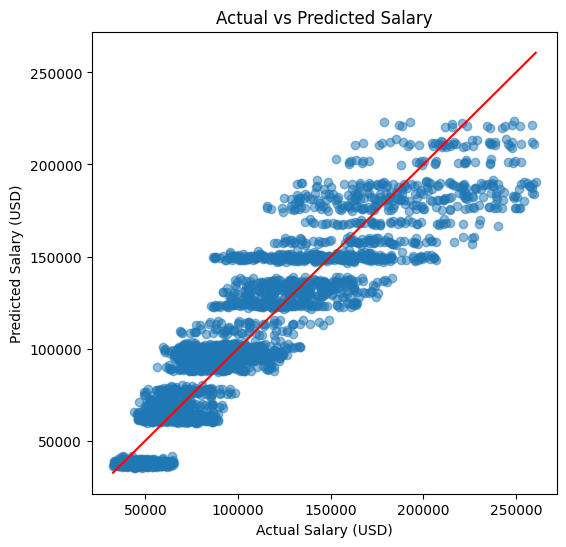

In [ ]:
y_pred_test = model.predict(X_test)
plt.figure(figsize=(6,6))

# Scatter plot
plt.scatter(y_test, y_pred_test, alpha=0.5)

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')

plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Actual vs Predicted Salary")

plt.show()


# Residual Plot
The residual plot shows the residuals scattered randomly around the zero line, with no clear pattern or curvature. This indicates that the linearity assumption of OLS is reasonably satisfied. The residuals exhibit roughly constant variance across predicted salary values, although some mild widening occurs at higher salary ranges, which is expected due to the natural variability of compensation data. Overall, the plot suggests that the Linear Regression model is appropriate for the dataset and does not suffer from major violations of OLS assumptions.

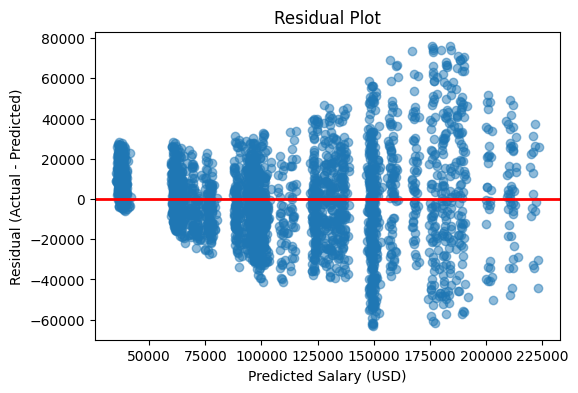

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
# Compute residuals
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)

# Horizontal line at 0 residual
plt.axhline(0, color='red', linewidth=2)

plt.xlabel("Predicted Salary (USD)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()


# Custom Testing

In [ ]:
test_input = pd.DataFrame({
    "years_experience": [5],
    "remote_ratio": [0],
    "experience_level": ["SE"],
    "job_title": ["Machine Learning Engineer"],
    "company_location": ["US"],
    "education_required": ["Bachelor"]
})
predicted_salary = model.predict(test_input)
print("Predicted Salary: $", round(predicted_salary[0], 2))
test_input = pd.DataFrame({
    "years_experience": [1],
    "remote_ratio": [100],
    "experience_level": ["SE"],
    "job_title": ["AI Software Engineer"],
    "company_location": ["US"],
    "education_required": ["Master"]
})
predicted_salary = model.predict(test_input)
print("Predicted Salary: $", round(predicted_salary[0], 2))


Predicted Salary: $ 122893.67
Predicted Salary: $ 123252.1


# Quantile Regression
- Quantile regression gives richer prediction than OLS
- https://www.sciencedirect.com/science/article/pii/S0885064X25000731

"Compared to mean regression, quantile regression can provide richer information about the distribution of the response variables."

For report: Can say something along the lines like: ...quantile regression provides richer information than traditional mean regression, we extend our model to include quantile regression to estimate lower, median, and upper salary predictions...

Here I am training all 3 quantiles:

0.5 - median

0.1 - 10%

0.9 - 90%

# Why do this?

Salary is NOT normally distributed. OLS tries to fit the mean, which is sensitive to extreme salaries. Quantile regression can estimate typical salary (50%), low-end salary (10%) and high-end salary (90%).

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(


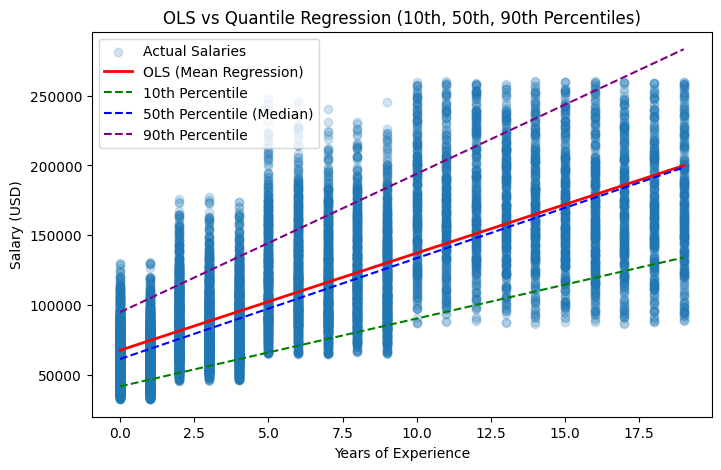

In [ ]:
from sklearn.linear_model import QuantileRegressor
# Prepare data for plotting
X_exp = df[['years_experience']]
y_salary = df['salary_usd']

# Grid of experience values for smooth curves
exp_grid = np.linspace(X_exp.min(), X_exp.max(), 200).reshape(-1, 1)

# OLS
ols = LinearRegression()
ols.fit(X_exp, y_salary)
ols_pred = ols.predict(exp_grid)

# Quantile Regressors
quantiles = [0.1, 0.5, 0.9]
qr_models = {}
qr_preds = {}

for q in quantiles:
    qr = QuantileRegressor(quantile=q, alpha=0)
    qr.fit(X_exp, y_salary)
    qr_models[q] = qr
    qr_preds[q] = qr.predict(exp_grid)


# Plot
plt.figure(figsize=(8,5))

# Scatter of actual salaries
plt.scatter(X_exp, y_salary, alpha=0.2, label="Actual Salaries")

# OLS (mean)
plt.plot(exp_grid, ols_pred, color='red', linewidth=2, label="OLS (Mean Regression)")

# Quantile lines
plt.plot(exp_grid, qr_preds[0.1], color='green', linestyle='--', label="10th Percentile")
plt.plot(exp_grid, qr_preds[0.5], color='blue', linestyle='--', label="50th Percentile (Median)")
plt.plot(exp_grid, qr_preds[0.9], color='purple', linestyle='--', label="90th Percentile")

plt.xlabel("Years of Experience")
plt.ylabel("Salary (USD)")
plt.title("OLS vs Quantile Regression (10th, 50th, 90th Percentiles)")
plt.legend()
plt.show()
